In [1]:
import itertools
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from scipy.stats import poisson
from functools import lru_cache
from tqdm.notebook import trange, tqdm

In [2]:
@lru_cache(maxsize=None)
def p_pmf(x, mu):
    return poisson.pmf(x, mu)


@lru_cache(maxsize=None)
def alpha_level(mu, epsilon):
    left, right = 0, 0
    iterator = itertools.count()
    for x in iterator:
        y = p_pmf(x, mu)
        if y >= epsilon:
            left = x
            break
    for x in iterator:
        y = p_pmf(x, mu)
        if y < epsilon:
            right = x
            break
    return left, right


def segment(start, stop, step=1):
    return range(start, stop + 1, step)


def apply_action(state, action):
    first, second = state
    return first - action, second + action


def clip(v, from_v, to_v):
    return max(from_v, min(to_v, v))


@dataclass
class PickUpPoint:
    issuance_mu: int
    returns_mu: int
    max_cars: int
    cost_of_parking_space: float


@dataclass
class JackCarRental:
    first_pickup: PickUpPoint
    second_pickup: PickUpPoint
    point_to_point_movement_cost: float
    point_to_point_movement_max_cars: int
    first_to_second_free_movement = 0
    second_to_first_free_movement = 0
    rent_prize: float
    theta = 65
    theta_degrade = 0.5
    epsilon = 0.01
    gamma = 0.9

    def iterate_states(self):
        out = list()
        for i in segment(0, self.first_pickup.max_cars):
            for j in segment(0, self.second_pickup.max_cars):
                out.append((i, j))
        return tuple(out)

    def iterate_actions(self, state):
        d = self.point_to_point_movement_max_cars
        out = list()
        for i in segment(-d, d):
            first, second = apply_action(state, i)
            if 0 <= first <= self.first_pickup.max_cars and \
                    0 <= second <= self.second_pickup.max_cars:
                out.append(i)
        return out

    def action_cost(self, action):
        free_first_to_second = self.first_to_second_free_movement
        free_second_to_first = self.second_to_first_free_movement
        free_ride = free_first_to_second if action >= 0 else free_second_to_first

        return max(abs(action) - free_ride, 0) * self.point_to_point_movement_cost

    def get_tax(self, state):
        first, second = state
        return self.first_pickup.cost_of_parking_space * first + self.second_pickup.cost_of_parking_space * second

    def action_evaluation(self, state, action, values):
        balance = 0

        balance += self.action_cost(action)

        first, second = apply_action(state, action)

        balance += self.get_tax((first, second))

        for first_cars_issued in segment(*alpha_level(self.first_pickup.issuance_mu, self.epsilon)):
            for first_cars_returned in segment(*alpha_level(self.first_pickup.returns_mu, self.epsilon)):
                for second_cars_issued in segment(*alpha_level(self.second_pickup.issuance_mu, self.epsilon)):
                    for second_cars_returned in segment(*alpha_level(self.second_pickup.returns_mu, self.epsilon)):
                        first_actually_issued, second_actually_issued = \
                            min(first, first_cars_issued), min(second, second_cars_issued)

                        new_state = \
                            min(first - first_actually_issued + first_cars_returned, self.first_pickup.max_cars), \
                                min(second - second_actually_issued + second_cars_returned, self.second_pickup.max_cars)

                        income = (first_actually_issued + second_actually_issued) * self.rent_prize
                        probability = \
                            p_pmf(first_cars_issued, self.first_pickup.issuance_mu) * \
                            p_pmf(first_cars_returned, self.first_pickup.returns_mu) * \
                            p_pmf(second_cars_issued, self.second_pickup.issuance_mu) * \
                            p_pmf(second_cars_returned, self.second_pickup.returns_mu)
                        balance += probability * (income + self.gamma * values[new_state])
        return balance

    def strategy_evaluation(self, values, strategy, curr_theta, i=0):
        t = tqdm(desc=f"{i}:strategy_evaluation")
        while True:
            new_values = np.zeros_like(values)
            delta = 0
            for s in self.iterate_states():
                new_values[s] = self.action_evaluation(s, strategy[s], values)
                delta = max(delta, abs(values[s] - new_values[s]))
            values = new_values
            if delta < curr_theta:
                break
            t.update()
        t.close()
        return new_values

    def strategy_improvement(self, values, old_strategy, i=0):
        policy_stable = True
        new_strategy = np.zeros_like(old_strategy)
        for s in tqdm(self.iterate_states(), desc=f"{i}:strategy_improvement"):
            old_action = old_strategy[s]

            new_action = old_action
            new_action_balance = 0
            for a in self.iterate_actions(s):
                b = self.action_evaluation(s, a, values)
                if b > new_action_balance:
                    new_action_balance = b
                    new_action = a

            new_strategy[s] = new_action

            if old_action != new_action:
                policy_stable = False
        return new_strategy, policy_stable

    def get_optimal_jack_strategy(self):
        shape = self.first_pickup.max_cars + 1, self.second_pickup.max_cars + 1
        values = np.zeros(shape)
        strategy = np.zeros(shape, dtype=int)
        strategy_history = [strategy]
        curr_theta = self.theta
        t = tqdm(desc="optimal_jack_strategy")
        for i in itertools.count(1):
            values = self.strategy_evaluation(values, strategy, curr_theta, i)
            strategy, policy_stable = self.strategy_improvement(values, strategy, i)
            strategy_history.append(strategy)
            curr_theta *= self.theta_degrade
            if policy_stable:
                break
            t.update()
        t.close()
        return values, strategy, strategy_history


In [3]:
def plot_grid(items, cols=3):
    n = len(items)
    rows = int(math.ceil(n / cols))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    for i, item in enumerate(items):
        ax = fig.add_subplot(gs[i])
        ax.imshow(item, cmap='viridis', vmin=-5, vmax=5, origin='lower')
    fig.tight_layout()
    plt.show()
    plt.imshow(items[-1], cmap='viridis', vmin=-5, vmax=5, origin='lower')
    plt.colorbar()
    plt.show()

In [4]:
rental = JackCarRental(first_pickup=PickUpPoint(3, 3, 20, 0), second_pickup=PickUpPoint(4, 2, 20, 0),
                       point_to_point_movement_cost=-2, point_to_point_movement_max_cars=5, rent_prize=10)
v, pi, history = rental.get_optimal_jack_strategy()

optimal_jack_strategy: 0it [00:00, ?it/s]

1:strategy_evaluation: 0it [00:00, ?it/s]

1:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

2:strategy_evaluation: 0it [00:00, ?it/s]

2:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

3:strategy_evaluation: 0it [00:00, ?it/s]

3:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

4:strategy_evaluation: 0it [00:00, ?it/s]

4:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

5:strategy_evaluation: 0it [00:00, ?it/s]

5:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

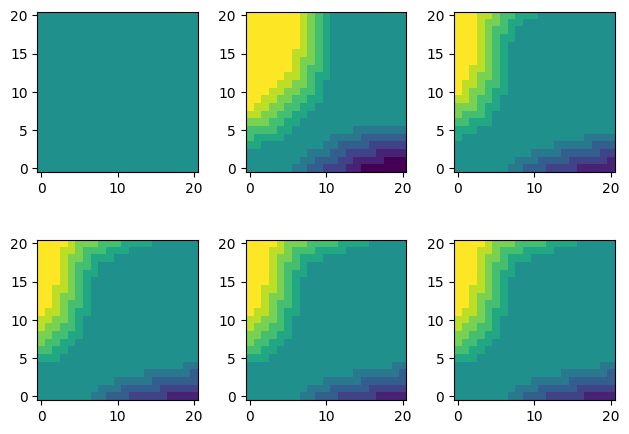

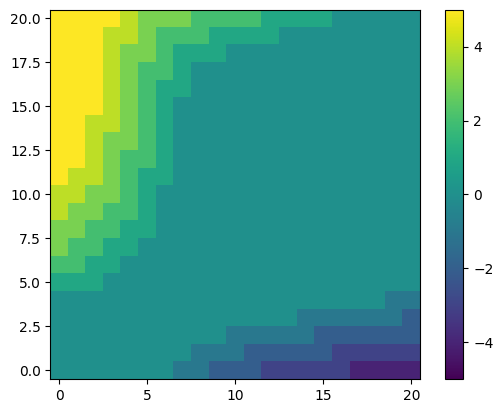

In [5]:
plot_grid(history)

In [6]:
rental2 = JackCarRental(first_pickup=PickUpPoint(3, 3, 20, -0.5), second_pickup=PickUpPoint(4, 2, 20, 0),
                       point_to_point_movement_cost=-2, point_to_point_movement_max_cars=5, rent_prize=10)
rental2.first_to_second_free_movement = 2
v2, pi2, history2 = rental2.get_optimal_jack_strategy()

optimal_jack_strategy: 0it [00:00, ?it/s]

1:strategy_evaluation: 0it [00:00, ?it/s]

1:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

2:strategy_evaluation: 0it [00:00, ?it/s]

2:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

3:strategy_evaluation: 0it [00:00, ?it/s]

3:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

4:strategy_evaluation: 0it [00:00, ?it/s]

4:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

5:strategy_evaluation: 0it [00:00, ?it/s]

5:strategy_improvement:   0%|          | 0/441 [00:00<?, ?it/s]

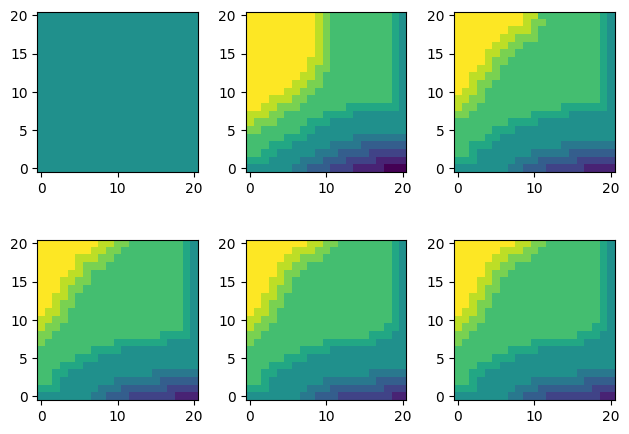

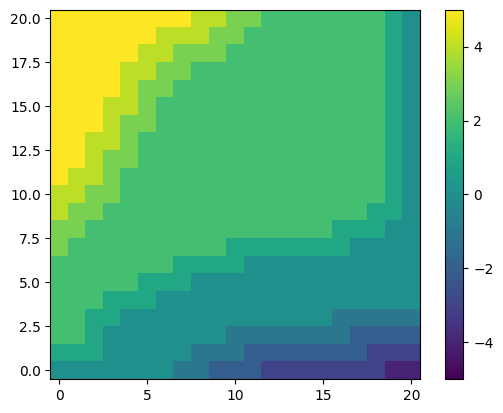

In [7]:
plot_grid(history2)